In [2]:
import pandas as pd

# Function to calculate mode
def calculate_mode(series):
    return series.mode().iloc[0] if not series.mode().empty else None

# Read the data
df = pd.read_csv('Indore.csv')

# Apply the season determination function
def determine_season(row):
    dbt = row['DBT mean']
    rh = row['RH mean']
    cloud_cover = row['Sky Cover mean']
    ghi = row['GHR mean']
    
    if dbt <= 23 and rh >= 40 and ghi <= 255:
        season = 'Winter'
    elif 22 < dbt <= 28 and rh <= 40 and 260 < ghi < 320:
        season = 'Spring'
    elif dbt > 28 and rh < 80 and ghi > 300:
        season = 'Summer'
    elif 26 < dbt < 30 and rh >=70  and ghi < 300 and cloud_cover > 4:
        season = 'Light Rainfall'
    elif 23 < dbt < 29 and rh >= 75 and ghi < 300 and cloud_cover > 6:
        season = 'Monsoon'
    elif 23 < dbt <= 27.5 and rh < 80 and ghi < 270 and cloud_cover < 6:
        season = 'Autumn'
    else:
        season = 'Unknown'

    return season

df['season'] = df.apply(determine_season, axis=1)

# Replace 'Unknown' seasons with the most frequent surrounding season
def replace_unknown_with_mode(df, window_size=3):
    seasons = df['season'].values
    for i in range(len(seasons)):
        if seasons[i] == 'Unknown':
            start = max(0, i - window_size)
            end = min(len(seasons), i + window_size + 1)
            surrounding_seasons = seasons[start:end]
            most_common_season = pd.Series([season for season in surrounding_seasons if season != 'Unknown']).mode()
            if not most_common_season.empty:
                seasons[i] = most_common_season[0]
    df['season'] = seasons
    return df

df = replace_unknown_with_mode(df)

# Calculate statistics for each season
season_stats = df.groupby('season').agg({
    'DBT mean': ['min', 'max', 'mean', 'std', calculate_mode],
    'RH mean': ['min', 'max', 'mean', 'std', calculate_mode],
    'GHR mean': ['min', 'max', 'mean', 'std', calculate_mode],
    'Sky Cover mean': ['min', 'max', 'mean', 'std', calculate_mode],
    'Wind Speed [m/s]': ['min', 'max', 'mean', calculate_mode],
    'Wind Direction [degrees]': ['min', 'max', 'mean', 'unique', calculate_mode]
})

# Rename columns for clarity
season_stats.columns = ['_'.join(col).strip() for col in season_stats.columns.values]
season_stats = season_stats.reset_index()

# Save the statistics to an Excel file
season_stats.to_excel('IndoreSeasonStatistics.xlsx', index=False)

# Optional: print the statistics
print(season_stats)


           season  DBT mean_min  DBT mean_max  DBT mean_mean  DBT mean_std  \
0          Autumn     22.616667     28.012500      25.516358      1.305956   
1  Light Rainfall     26.295833     30.458333      27.343364      0.931215   
2         Monsoon     23.125000     28.112500      24.660455      0.847828   
3          Spring     21.979167     27.983333      25.514881      1.782191   
4          Summer     28.004167     33.837500      31.082182      1.665949   
5          Winter     14.558333     22.929167      19.537323      1.887059   

   DBT mean_calculate_mode  RH mean_min  RH mean_max  RH mean_mean  \
0                25.208333    36.291667    82.875000     55.983796   
1                27.866667    61.833333    82.541667     75.558642   
2                23.125000    69.833333    96.458333     86.543182   
3                21.979167    13.875000    50.166667     28.782143   
4                31.345833    16.583333    65.958333     34.669956   
5                18.500000    37.

: 

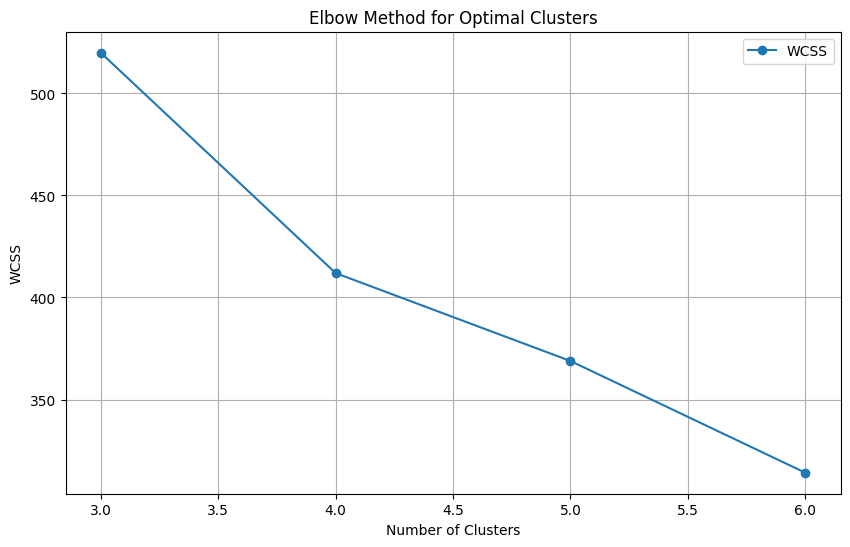

Optimal number of clusters based on silhouette score: 3
Clustered data saved to C:/Users/Alok Kumar Pandey/OneDrive/Desktop/coding/delhi raw file trial2.xlsx


In [2]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Load the data
file_path = 'C:/Users/Alok Kumar Pandey/OneDrive/Desktop/coding/delhi raw file.xlsx'  # Replace with your file path
data = pd.read_excel(file_path)

# Calculate daily statistics
data['Date'] = pd.to_datetime(data[['Year', 'Month', 'Day']])
daily_data = data.groupby('Date').agg({
    'Dry Bulb Temperature': ['min', 'max'],
    'Relative Humidity': 'mean',
    'Global Horizontal Radiation': lambda x: x[x > 50].mean()
}).dropna()

daily_data.columns = ['Dry Bulb Temp Min', 'Dry Bulb Temp Max', 'Relative Humidity Mean', 'Global Horizontal Radiation Mean']

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(daily_data)

# Determine the optimal number of clusters (between 3 and 6) using both the elbow method and silhouette score
wcss = []
silhouette_scores = []

for k in range(3, 7):
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(data_scaled)
    wcss.append(kmeans.inertia_)
    silhouette_avg = silhouette_score(data_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot the elbow method graph
plt.figure(figsize=(10, 6))
plt.plot(range(3, 7), wcss, marker='o', label='WCSS')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal Clusters')
plt.legend()
plt.grid(True)
plt.show()

# Determine the optimal number of clusters based on the silhouette score
best_k = 3
best_score = max(silhouette_scores)
best_k = silhouette_scores.index(best_score) + 3

print(f"Optimal number of clusters based on silhouette score: {best_k}")

# Apply KMeans with the optimal number of clusters
kmeans = KMeans(n_clusters=best_k, random_state=42)
daily_data['Cluster'] = kmeans.fit_predict(data_scaled)

# Save the results to a new Excel file
output_file_path = 'C:/Users/Alok Kumar Pandey/OneDrive/Desktop/coding/delhi raw file trial2.xlsx'  # Replace with the desired output file path
daily_data.to_excel(output_file_path, index=False)

print(f"Clustered data saved to {output_file_path}")


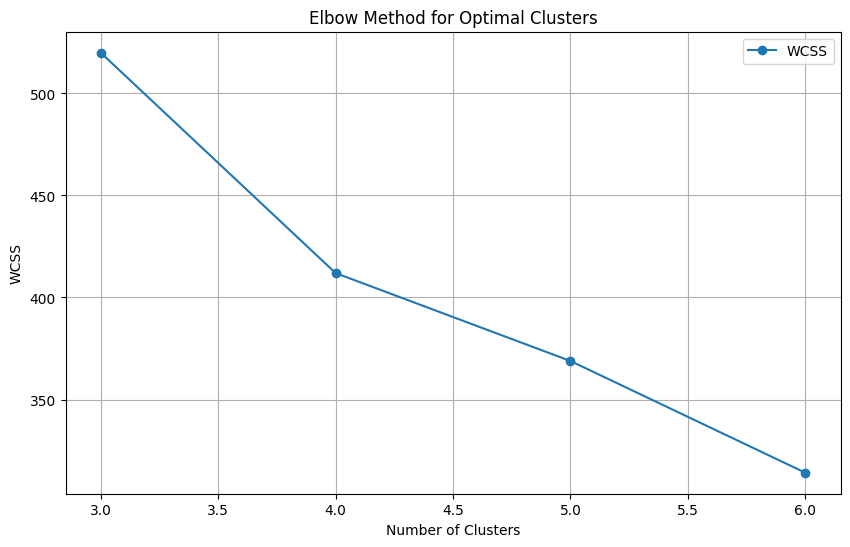

Initial optimal number of clusters based on silhouette score: 3
Adjusted optimal number of clusters: 3
Clustered data saved to C:/Users/Alok Kumar Pandey/OneDrive/Desktop/coding/delhi raw file trial4.xlsx


In [1]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Load the data
file_path = 'C:/Users/Alok Kumar Pandey/OneDrive/Desktop/coding/delhi raw file.xlsx'  # Replace with your file path
data = pd.read_excel(file_path)

# Calculate daily statistics
data['Date'] = pd.to_datetime(data[['Year', 'Month', 'Day']])
daily_data = data.groupby('Date').agg({
    'Dry Bulb Temperature': ['min', 'max'],
    'Relative Humidity': 'mean',
    'Global Horizontal Radiation': lambda x: x[x > 50].mean()
}).dropna()

daily_data.columns = ['Dry Bulb Temp Min', 'Dry Bulb Temp Max', 'Relative Humidity Mean', 'Global Horizontal Radiation Mean']

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(daily_data)

# Determine the optimal number of clusters (between 3 and 6) using both the elbow method and silhouette score
wcss = []
silhouette_scores = []

for k in range(3, 7):
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(data_scaled)
    wcss.append(kmeans.inertia_)
    silhouette_avg = silhouette_score(data_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot the elbow method graph
plt.figure(figsize=(10, 6))
plt.plot(range(3, 7), wcss, marker='o', label='WCSS')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal Clusters')
plt.legend()
plt.grid(True)
plt.show()

# Determine the optimal number of clusters based on the silhouette score
best_k = silhouette_scores.index(max(silhouette_scores)) + 3
print(f"Initial optimal number of clusters based on silhouette score: {best_k}")

# Apply KMeans with the optimal number of clusters, ensuring each cluster has at least 30 days
def check_cluster_sizes(labels, min_size=30):
    unique, counts = np.unique(labels, return_counts=True)
    return np.all(counts >= min_size)

while best_k >= 3:
    kmeans = KMeans(n_clusters=best_k, random_state=42)
    cluster_labels = kmeans.fit_predict(data_scaled)
    
    if check_cluster_sizes(cluster_labels):
        daily_data['Cluster'] = cluster_labels
        break
    else:
        best_k -= 1

print(f"Adjusted optimal number of clusters: {best_k}")

# Save the results to a new Excel file
output_file_path = 'C:/Users/Alok Kumar Pandey/OneDrive/Desktop/coding/delhi raw file trial4.xlsx'  # Replace with the desired output file path
daily_data.to_excel(output_file_path, index=False)

print(f"Clustered data saved to {output_file_path}")


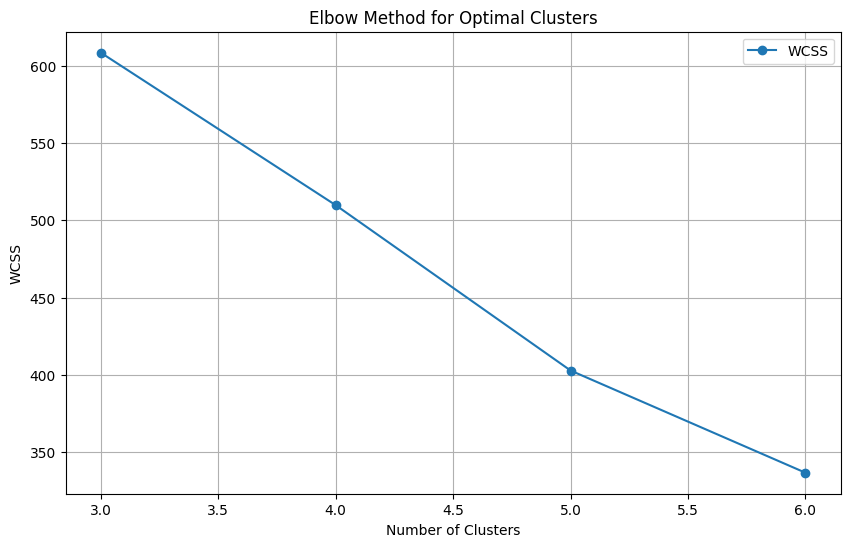

Initial optimal number of clusters based on silhouette score: 3
Adjusted optimal number of clusters: 3
Clustered data saved to C:/Users/Alok Kumar Pandey/OneDrive/Desktop/coding/delhi raw file trial5.xlsx


In [4]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Load the data
file_path = 'C:/Users/Alok Kumar Pandey/OneDrive/Desktop/coding/delhi raw file.xlsx'  # Replace with your file path
data = pd.read_excel(file_path)

# Calculate daily statistics
data['Date'] = pd.to_datetime(data[['Year', 'Month', 'Day']])
daily_data = data.groupby('Date').agg({
    'Dry Bulb Temperature': ['min', 'max', 'mean'],
    'Relative Humidity': 'mean',
    'Global Horizontal Radiation': lambda x: x[x > 50].mean()
}).dropna()

# Rename the columns
daily_data.columns = ['Dry Bulb Temp Min', 'Dry Bulb Temp Max', 'Dry Bulb Temp Mean', 'Relative Humidity Mean', 'Global Horizontal Radiation Mean']

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(daily_data)

# Determine the optimal number of clusters (between 3 and 6) using both the elbow method and silhouette score
wcss = []
silhouette_scores = []

for k in range(3, 7):
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(data_scaled)
    wcss.append(kmeans.inertia_)
    silhouette_avg = silhouette_score(data_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot the elbow method graph
plt.figure(figsize=(10, 6))
plt.plot(range(3, 7), wcss, marker='o', label='WCSS')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal Clusters')
plt.legend()
plt.grid(True)
plt.show()

# Determine the optimal number of clusters based on the silhouette score
best_k = silhouette_scores.index(max(silhouette_scores)) + 3
print(f"Initial optimal number of clusters based on silhouette score: {best_k}")

# Apply KMeans with the optimal number of clusters, ensuring each cluster has at least 30 days
def check_cluster_sizes(labels, min_size=30):
    unique, counts = np.unique(labels, return_counts=True)
    return np.all(counts >= min_size)

while best_k >= 3:
    kmeans = KMeans(n_clusters=best_k, random_state=42)
    cluster_labels = kmeans.fit_predict(data_scaled)
    
    if check_cluster_sizes(cluster_labels):
        daily_data['Cluster'] = cluster_labels
        break
    else:
        best_k -= 1

print(f"Adjusted optimal number of clusters: {best_k}")

# Save the results to a new Excel file
output_file_path = 'C:/Users/Alok Kumar Pandey/OneDrive/Desktop/coding/delhi raw file trial5.xlsx'  # Replace with the desired output file path
daily_data.to_excel(output_file_path, index=False)

print(f"Clustered data saved to {output_file_path}")


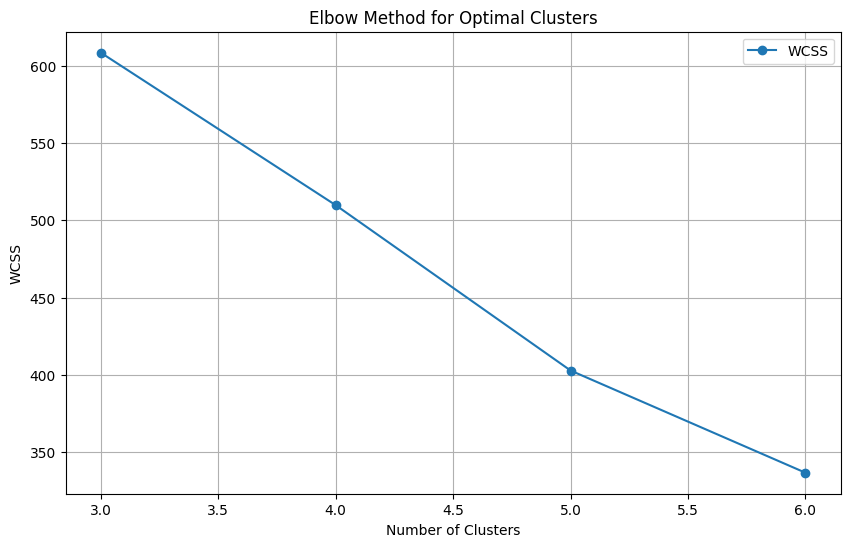

Optimal number of clusters based on silhouette score: 3
Clustered data saved to C:/Users/Alok Kumar Pandey/OneDrive/Desktop/coding/delhi raw file trial7.xlsx


In [5]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Load the data
file_path = 'C:/Users/Alok Kumar Pandey/OneDrive/Desktop/coding/delhi raw file.xlsx'  # Replace with your file path
data = pd.read_excel(file_path)

# Calculate daily statistics
data['Date'] = pd.to_datetime(data[['Year', 'Month', 'Day']])
daily_data = data.groupby('Date').agg({
    'Dry Bulb Temperature': ['min', 'max', 'mean'],
    'Relative Humidity': 'mean',
    'Global Horizontal Radiation': lambda x: x[x > 50].mean()
}).dropna()

# Rename the columns
daily_data.columns = ['Dry Bulb Temp Min', 'Dry Bulb Temp Max', 'Dry Bulb Temp Mean', 'Relative Humidity Mean', 'Global Horizontal Radiation Mean']

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(daily_data)

# Determine the optimal number of clusters (between 3 and 6) using both the elbow method and silhouette score
wcss = []
silhouette_scores = []

for k in range(3, 7):
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(data_scaled)
    wcss.append(kmeans.inertia_)
    silhouette_avg = silhouette_score(data_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot the elbow method graph
plt.figure(figsize=(10, 6))
plt.plot(range(3, 7), wcss, marker='o', label='WCSS')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal Clusters')
plt.legend()
plt.grid(True)
plt.show()

# Determine the optimal number of clusters based on the silhouette score
best_k = silhouette_scores.index(max(silhouette_scores)) + 3
print(f"Optimal number of clusters based on silhouette score: {best_k}")

# Apply KMeans with the optimal number of clusters
kmeans = KMeans(n_clusters=best_k, random_state=42)
daily_data['Cluster'] = kmeans.fit_predict(data_scaled)

# Save the results to a new Excel file
output_file_path = 'C:/Users/Alok Kumar Pandey/OneDrive/Desktop/coding/delhi raw file trial7.xlsx'  # Replace with the desired output file path
daily_data.to_excel(output_file_path, index=False)

print(f"Clustered data saved to {output_file_path}")


In [6]:
import pandas as pd
from sklearn.cluster import KMeans

# Load the data from the uploaded Excel file
file_path = 'C:/Users/Alok Kumar Pandey/OneDrive/Desktop/coding/delhi raw file.xlsx'
df = pd.read_excel(file_path)

# Convert the datetime column to datetime format and extract the day
df['datetime'] = pd.to_datetime(df['datetime'])
df['Day'] = df['datetime'].dt.date

# Group by day and calculate the required statistics
daily_data = df.groupby('Day').agg(
    Dry_Bulb_Temp_Min=('Dry Bulb Temperature', 'min'),
    Dry_Bulb_Temp_Max=('Dry Bulb Temperature', 'max'),
    Relative_Humidity_Mean=('Relative Humidity', 'mean'),
    Global_Horizontal_Radiation_Mean=('Global Horizontal Radiation', lambda x: x[x > 50].mean())
).dropna()

# Function to perform K-means clustering with the specified number of clusters
def kmeans_clustering(data, min_clusters=3, max_clusters=6):
    from sklearn.cluster import KMeans
    import numpy as np

    results = {}
    for n_clusters in range(min_clusters, max_clusters + 1):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(data)
        labels = kmeans.labels_
        cluster_counts = np.bincount(labels)
        if all(cluster_counts >= 30):  # Ensure each cluster has at least 30 days
            results[n_clusters] = cluster_counts
    return results

# Prepare the data for clustering
clustering_data = daily_data[['Dry_Bulb_Temp_Min', 'Dry_Bulb_Temp_Max', 'Relative_Humidity_Mean', 'Global_Horizontal_Radiation_Mean']]

# Perform clustering
cluster_results = kmeans_clustering(clustering_data)

# Perform final clustering with 3 clusters
kmeans_final = KMeans(n_clusters=3, random_state=42).fit(clustering_data)
daily_data['Cluster'] = kmeans_final.labels_

# Count the number of days in each cluster
cluster_counts_final = daily_data['Cluster'].value_counts()

# Display the final clustering results
print(cluster_counts_final)


Cluster
1    162
0    149
2     54
Name: count, dtype: int64
